In [ ]:
!pip install mpi4py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 12.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.4-cp38-cp38-linux_x86_64.whl size=4438513 sha256=77ba00ebb8f6b2a7f106d3da1ec3bf4ced4294ad247856afb24e5592931de3de
  Stored in directory: /root/.cache/pip/wheels/f3/35/48/0b9a7076995eea5ea64a7e4bc3f0f342f453080795276264e7
Successfully built mpi4py


In [ ]:
from mpi4py import MPI

import numpy as np
import matplotlib.pyplot as plt
import cmath
%matplotlib inline

from scipy.signal import argrelextrema
import seaborn as sns

from tqdm.notebook import tqdm
import os
import imageio
import time 

plt.rcParams['figure.figsize'] = (11, 7)
plt.rcParams['font.size'] = 20
plt.rcParams['image.cmap'] = 'binary'

In [ ]:
%%writefile get_spectogram.py
import numpy as np

def get_specgram(t, y, window_positions, window_width, freq_limit=10):
    t_space = t
    w_spec = np.fft.fftfreq(len(y), d=(t_space[1]-t_space[0]) / 2 / np.pi)

    freq_limit_idx = np.where(w_spec >= freq_limit)[0][0] if freq_limit else -1
    w_spec = w_spec[:freq_limit_idx]
    
    spec_per_step = np.array([]).reshape(0, freq_limit_idx)
    for w_pos in window_positions:        
        window_function = np.exp(-(t_space - w_pos) ** 2 / 2 / window_width ** 2)
        y_window = y * window_function
        
        sp = np.fft.fft(y_window)
        sp = np.abs(sp) ** 2
        sp = sp[:freq_limit_idx]
        spec_per_step = np.vstack([spec_per_step, sp])
        
    spec_per_step = np.array(spec_per_step).T
    return w_spec, spec_per_step, window_width

Writing get_spectogram.py


In [ ]:
%%writefile parallel_spectrogram.py

from mpi4py import MPI
import numpy as np
from get_spectogram import *
import time

comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()

mpi_wall_t = MPI.Wtime()
calc_t = time.time()

t = np.linspace(-20*2*np.pi, 20*2*np.pi, 3**15)

y = np.sin(t) * np.exp(-t**2/2/20**2)
y = y + np.sin(3*t) * np.exp(-(t-5*2*np.pi)**2/2/20**2)
y = y + np.sin(5.5*t) * np.exp(-(t-10*2*np.pi)**2/2/5**2)
y = y + np.sin(4*t) * np.exp(-(t-7*2*np.pi)**2/2/20**2)

nwindowsteps = 60 if size != 7 else 63
window_width = (t[-1] - t[0]) / nwindowsteps
window_positions_space = np.linspace(t[0], t[-1], nwindowsteps)

win_pos_per_rank = np.split(window_positions_space, size)
win_pos_subspace = win_pos_per_rank[rank]

_, spec_per_step, _ = get_specgram(t, y, win_pos_subspace, window_width)

calc_t = time.time() - calc_t
mpi_wall_t = MPI.Wtime() - mpi_wall_t

gather_t = time.time()
result_arr = comm.gather(spec_per_step, root=0)
gather_t = time.time() - gather_t

if rank == 0:
    result_arr = np.concatenate(result_arr, 1)
    np.savez('result_' + str(size) + '.npz', arr_0=result_arr,
             calc_t=calc_t, gather_t=gather_t, mpi_wall_t=mpi_wall_t)

Writing parallel_spectrogram.py


In [ ]:
!mpirun --allow-run-as-root -n 1 python parallel_spectrogram.py

In [ ]:
!mpirun --allow-run-as-root -n 2 python parallel_spectrogram.py

In [ ]:
!mpirun --allow-run-as-root -n 3 python parallel_spectrogram.py

In [ ]:
!mpirun --allow-run-as-root -n 4 python parallel_spectrogram.py

In [ ]:
!mpirun --allow-run-as-root -n 5 python parallel_spectrogram.py

In [ ]:
!mpirun --allow-run-as-root -n 6 python parallel_spectrogram.py

In [ ]:
!mpirun --allow-run-as-root -n 7 python parallel_spectrogram.py

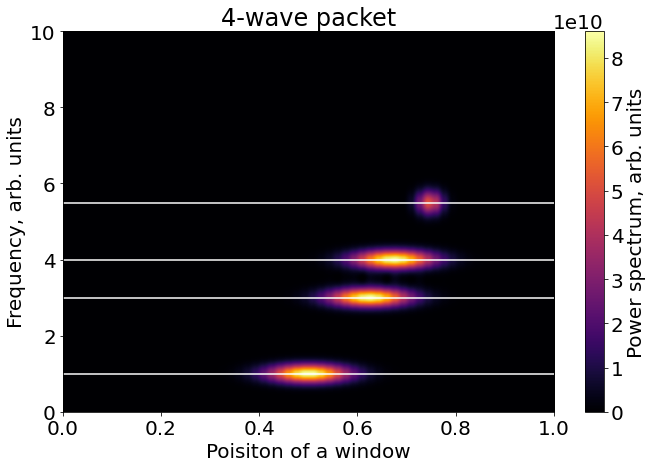

In [ ]:
source = np.load('result_4.npz')
spec_per_step = source['arr_0']
plt.imshow(spec_per_step, aspect='auto', cmap='inferno', origin='lower', extent=[0, 1, 0, 10])
plt.hlines([1, 3, 4, 5.5], [0, 0, 0, 0], [1, 1, 1, 1], color='w')
plt.colorbar(label='Power spectrum, arb. units')

plt.ylabel('Frequency, arb. units')
plt.xlabel('Poisiton of a window')
plt.title('4-wave packet');

## Speedup

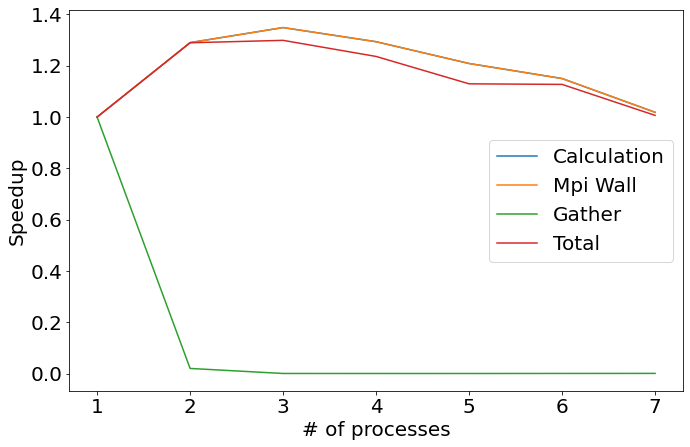

In [ ]:
calc_t = np.array([])
gather_t = np.array([])
mpi_wall_t = np.array([])

for i in range(1, 8):
    source = np.load('result_' + str(i) + '.npz')
    calc_t = np.append(calc_t, source['calc_t'])
    gather_t = np.append(gather_t, source['gather_t'])
    mpi_wall_t = np.append(mpi_wall_t, source['mpi_wall_t'])
total_t = calc_t + gather_t

_, axes = plt.subplots(1, 1, figsize=(11, 7))

axes.plot(range(1, 8), calc_t[0] / calc_t, label='Calculation')
axes.plot(range(1, 8), mpi_wall_t[0] / mpi_wall_t, label='Mpi Wall')
axes.plot(range(1, 8), gather_t[0] / gather_t, label='Gather')
axes.plot(range(1, 8), total_t[0] / total_t, label='Total')

axes.set_xlabel('# of processes')
axes.set_ylabel('Speedup')
axes.legend()

## Speedup 2.0

In [ ]:
t_1 = time.time()
!mpirun --allow-run-as-root -n 1 python parallel_spectrogram.py
t_1 = time.time() - t_1

In [ ]:
t_2 = time.time()
!mpirun --allow-run-as-root -n 2 python parallel_spectrogram.py
t_2 = time.time() - t_2

In [ ]:
t_3 = time.time()
!mpirun --allow-run-as-root -n 3 python parallel_spectrogram.py
t_3 = time.time() - t_3

In [ ]:
t_4 = time.time()
!mpirun --allow-run-as-root -n 4 python parallel_spectrogram.py
t_4 = time.time() - t_4

In [ ]:
t_5 = time.time()
!mpirun --allow-run-as-root -n 5 python parallel_spectrogram.py
t_5 = time.time() - t_5

In [ ]:
t_6 = time.time()
!mpirun --allow-run-as-root -n 6 python parallel_spectrogram.py
t_6 = time.time() - t_6

In [ ]:
t_7 = time.time()
!mpirun --allow-run-as-root -n 7 python parallel_spectrogram.py
t_7 = time.time() - t_7

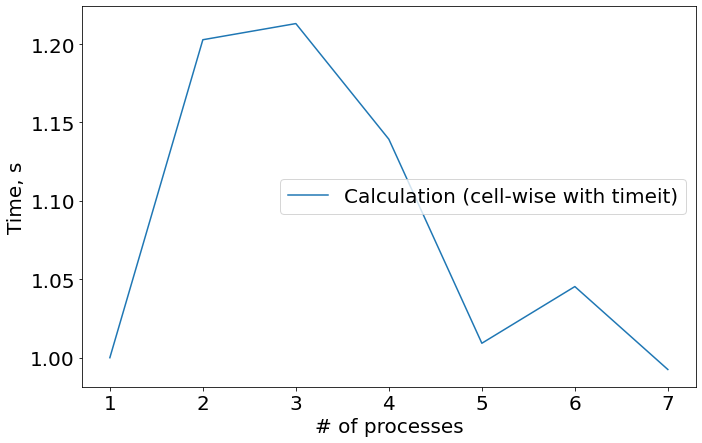

In [ ]:
plt.plot(range(1, 8), t_1 / np.array([t_1, t_2, t_3, t_4, t_5, t_6, t_7]), label='Calculation (cell-wise with timeit)')

plt.xlabel('# of processes')
plt.ylabel('Time, s')
plt.legend();